# Law, Order, and Algorithms
## Algorithmic fairness (1/2)

In 2016, ProPublica published a [now-famous article](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing) analyzing and criticizing the lack of fairness in a risk assessment tool used nationwide called COMPAS. Here, we will take a look at a cleaned-up version of the COMPAS data that ProPublica used, and try to better understand algorithmic fairness by investigating the claims ProPublica made, along with the [counterclaims](https://www.propublica.org/article/technical-response-to-northpointe) made by Northpointe (now re-branded as [Equivant](https://www.equivant.com/)).

While Northpointe notes that their algorithm does not use race information and that their model is _calibrated_ across racial groups, ProPublica points out that the COMPAS scores differ in false positive rates across racial groups (violating classification parity). In this notebook, we will examine some of their claims by building and evaluating our own risk assessment tool.

In [1]:
# Some initial setup
options(digits = 3)
library(tidyverse)

theme_set(theme_bw())

# Because huge plots are ugly
options(repr.plot.width = 6, repr.plot.height = 4)

# Read the data
compas_df <- read_rds("../data/compas.rds")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


## COMPAS data

A cleaned version of the COMPAS data is loaded as `compas_df`, with the following columns

* `id`: unique identifiers for each case
* `sex`, `dob`, `age`, `race`: demographic information for each defendant
* `recid_score`, `violence_score`: COMPAS scores assessing risk that a defendant will recidivate (`violence_score` for violent crimes) within two years of release (higher scores correspond to higher risk)
* `priors_count`: number of prior arrests
* `is_recid`, `is_violent_recid`: Indicator variable that is `1` if the defendant was arrested for a new (violent) crime within two years of release, and `0` otherwise

In [2]:
head(compas_df)

id,sex,dob,age,race,recid_score,violence_score,priors_count,is_recid,is_violent_recid
3,Male,1982-01-22,34,African-American,3,1,0,1,1
4,Male,1991-05-14,24,African-American,4,3,4,1,0
5,Male,1993-01-21,23,African-American,8,6,1,0,0
8,Male,1974-07-23,41,Caucasian,6,2,14,1,0
10,Female,1976-06-03,39,Caucasian,1,1,0,0,0
13,Male,1994-06-10,21,Caucasian,3,5,1,1,1


### Exercise 1: Build a risk assessment model for recidivism

We start by building our own risk assessment tool using only prior arrests (`priors_count`) and age (`age`) to predict whether a defendant will recidivate within two years of release (`is_recid`).
First, fit a model to estimate the probability of this outcome for each defendant. 
We will call this model `recid_model`.

In [4]:
# Build a logistic regression model estimating recidivism probability

recid_model <- 
# WRITE CODE HERE
# START solution
    glm(is_recid ~ priors_count + age, data = compas_df, family = "binomial")
# END solution

Given an estimate of risk (on the probability scale), we can compute a binary prediction of whether a defendant will recidivate or not by setting a decision threshold.
Once a threshold is determined, defendants with estimated risk higher or equal to the threshold are predicted to recidivate.
We can then compare the binary prediction to the observed outcome (`is_recid`) to compute the accuracy of our risk assessment tool at the specified threshold.
We can similarly compute accuracy for COMPAS scores (`recid_score`) with some threshold.

Calculate the accuracy for the `recid_model` that you fit above at a $50$% threshold, and for the COMPAS recidivism scores at a threshold of $4$ (which corresponds to approximately $50$%). To do so, first create a new column in the `compas_df` dataframe for estimated risk from your model above using the `predict()` function. Recall that you can generate model predictions with the command `predict(recid_model, type = "response")`, where `type = "response"` ensures predictions are in terms of probabilities, rather than log-odds. Then create a new binary column that indicates, for each person, whether their estimated risk is at least 50%. Similarly create a binary column that indicates whether their `recid_score` is at least 4. Finally, calculate accuracy (separately for the two binary predictors that you just created) by determining what proportion of the predictions align with the actual observed recidivism (`is_recid`).

In [5]:
# WRITE CODE HERE
# START solution
compas_df <- compas_df %>%
    mutate(
        risk = predict(recid_model, type = "response"),
        pred_recid = risk >= 0.5,
        compas_pred_recid = recid_score >= 4
    )

# Calculate accuracy
compas_df %>%
    summarize(
        accuracy = mean(pred_recid == is_recid),
        compas_accuracy = mean(compas_pred_recid == is_recid)
    )
# END solution

accuracy,compas_accuracy
<dbl>,<dbl>
0.675,0.643


### Exercise 2: Calibration

We next examine how well our model is calibrated across different race groups (i.e., for people who receive similar risk scores, we'll check whether the actual rate of recidivism is similar across race groups).

To do so, we calculate two quantities:
* `predicted_risk_score`: a discretized (rounded) version of our predicted risk from Exercise 1, similar to the COMPAS risk score;
* `recidivism_rate`: the actual recidivism rate of people within a specific discretized risk score bucket.

Calculate the above two quantities for both race groups in our dataset by creating a data frame called `calibration_by_race` containing three columns: `race`, `predicted_risk_score` (rounded to the nearest 10 percentage points), `recidivism_rate`.

_Hint_: `round(x)` will round each element of `x` to the nearest integer.

In [6]:
# Calculate discretized risk score

calibration_by_race <- compas_df %>%
# WRITE CODE HERE
# START solution
    mutate(predicted_risk_score = round(risk * 10)/10) %>%
    group_by(race, predicted_risk_score) %>%
    summarize(recidivism_rate = mean(is_recid))
# END solution

# Put the recidivism rates of different race groups side by side
calibration_by_race %>%
    spread(race, recidivism_rate)

`summarise()` regrouping output by 'race' (override with `.groups` argument)


predicted_risk_score,African-American,Caucasian
<dbl>,<dbl>,<dbl>
0.1,0.148,0.150
0.2,0.266,0.197
0.3,0.279,0.306
0.4,0.354,0.398
0.5,0.472,0.436
0.6,0.707,0.590
0.7,0.757,0.790
0.8,0.788,0.768
0.9,0.856,0.800


We can also visualize model calibration by plotting the risk score bins with their corresponding emprical recidivism rate:

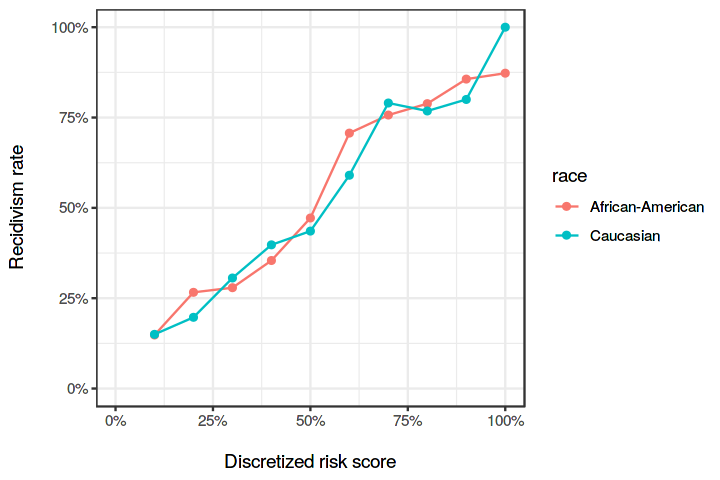

In [12]:
# Calibration plot
ggplot(calibration_by_race, 
       aes(x = predicted_risk_score, y = recidivism_rate, color = race)) +
    geom_line() + geom_point() +
    scale_y_continuous(labels = scales::percent_format(), limits = c(0, 1)) +
    scale_x_continuous(labels = scales::percent_format(), limits = c(0, 1)) +
    labs(x = "\nDiscretized risk score",
         y = "Recidivism rate\n")

The plot above suggets our model is well calibrated for Black and white defendants.
In other words, Black and white defendants who receive similar risk scores have similar risk of recidivating.

### Exercise 3: Cost-benefit analysis

Detaining an individual incurs substantial social and financial costs, 
yet releasing a defendant can harm public safety.
One strategy is to detain individuals with high recidivism risk while releasing those with low recidivism risk.
In order to make such a detention policy based on our model, we need to decide on a detention threshold.

To inform the detention decision, we'll attempt to estimate, for any given detention threshold,
the proportion of crimes that would be prevented and at what cost.
For the former, for a hypothetical detention policy, we'll estimate the proportion of defendants detained under that (hypothetical) policy who were in reality observed committing another crime. This measure, while imperfect, is a proxy for the the number of crimes prevented by detaining those individuals.
For the latter, we'll compute the proportion of all defendants that are detained under the policy.

This exercise is predicated on the assumption that it is acceptable to detain (at least some) individuals pretrial. 
Many, though, argue that (nearly) all defendants should be released on their own recognizance, in part because they have not yet been convicted of a crime. Further, even modest bail requirements can impose disproportionate burdens on the most vulnerable members of society. Some jurisdictions have taken steps toward reforming the pretrial processs — including [ending cash bail](https://www.npr.org/2021/02/22/970378490/illinois-becomes-first-state-to-eliminate-cash-bail) — though pretrial detention is still the norm rather than the exception.

To examine hypothetical detention policies, complete the following function, which, given a data frame and a threshold, returns a new data frame including two columns: 
* `prop_crime_prevented`: the proportion of crime that is prevented under the policy (i.e., the estimated number of crimes prevented under the policy divided by the total number of observed crimes)
* `prop_detained`: the proportion of the population that is detained under the policy

We will assume that the data frame passed to the function contains at least the following columns:
* `risk`: risk score that is used for the policy
* `is_recid`: outcome indicating whether a defendant recidiviated

In [6]:
calc_cost_benefit <- function(d, threshold){
    d %>%
# WRITE CODE HERE
# START solution    
        mutate(detained = risk > threshold) %>%
        summarize(
            num_crime_prevented = sum(is_recid & detained),
            prop_crime_prevented = num_crime_prevented/sum(is_recid),
            num_detained = sum(detained),
            prop_detained = num_detained/n()
        )    
# END solution
}

calc_cost_benefit(compas_df, threshold = 0.5)

num_crime_prevented,prop_crime_prevented,num_detained,prop_detained
<int>,<dbl>,<int>,<dbl>
2073,0.677,3084,0.501


Explore the cost-benefit characteristics of different policies that use different thresholds. 

We can also plot this cost-benefit tradeoff for all possible detention thresholds using the following code:

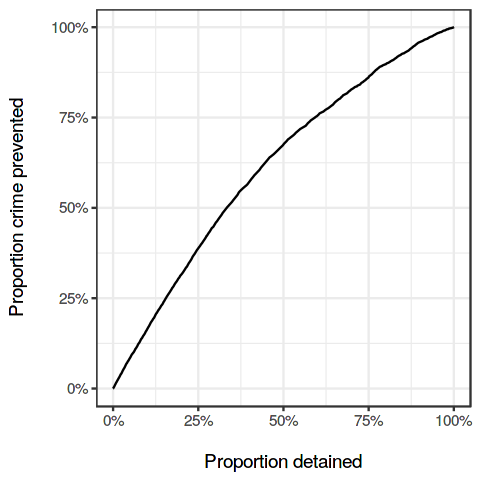

In [7]:
cost_benefit_df <- map_dfr(unique(compas_df$risk), # for each unique value of risk
                           ~ calc_cost_benefit(compas_df, .) %>% # calculate the costs and benefits
                               mutate(threshold = .x)) # append the corresponding thresholds

# Plot proportion detained vs. proportion crime prevented
options(repr.plot.width = 4, repr.plot.height = 4)
ggplot(cost_benefit_df, aes(x=prop_detained, y=prop_crime_prevented)) +
    geom_line()+
    scale_y_continuous(labels = scales::percent_format(), limits=c(0, 1))+
    scale_x_continuous(labels = scales::percent_format(), limits=c(0, 1))+
    labs(x = "\nProportion detained",
         y = "Proportion crime prevented\n")

### Exercise 4: Disparities in detention

By conducting the above cost-benefit analysis,
we can decide on a detention threshold, say 0.5, that we believe can maximize our benefit (crime prevention) at an acceptable cost of detaining some of the riskest defendants according to our model.

Now, we would like to know whether such a facially neutral policy, where we detain everyone at the same threshold, will introduce disparities across defendants belonging to different race groups.

To do so, let's compute the dentention rate for each race group using a detention threshold of 0.5.

In [13]:
# Calculate detention rate by race

# WRITE CODE HERE
# START solution
compas_df %>%
    mutate(detained = risk >= 0.5) %>%
    group_by(race) %>%
    summarize(
        detention_rate = mean(detained)
    )
# END solution

`summarise()` ungrouping output (override with `.groups` argument)


race,detention_rate
<chr>,<dbl>
African-American,0.604
Caucasian,0.347


Despite the same detention threshold being used, we still observe a difference in dentention rates.

To further investigate, we can plot the distribution of risk for each of the two groups:

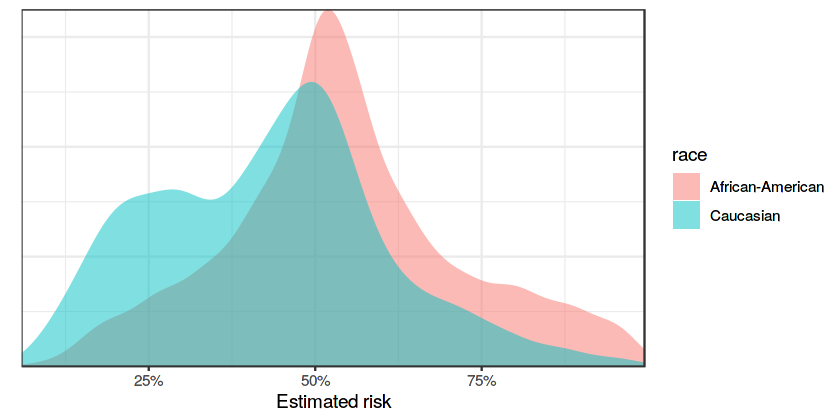

In [10]:
# Plot the risk distribution
options(repr.plot.width = 7, repr.plot.height = 3.5)
ggplot(compas_df, aes(x = risk, fill = race)) +
    geom_density(alpha = 0.5, color = NA) +
    scale_x_continuous("Estimated risk", labels = scales::percent_format(), expand = c(0, 0)) +
    scale_y_continuous(element_blank(), expand = c(0, 0)) +
    theme(axis.ticks.y = element_blank(),
          axis.text.y = element_blank())

Assuming that our model provides an accurate assessment of risk, we see that white and Black defendents have different risk distributions.

Note: When considering disparate treatment, we are often concerned with what happens at the margin 
(e.g., whether the same standard is applied to all individuals).
However, as we've seen in the past, popular summary statistics assess behavior away from the margin, hence they are called _infra-marginal_ statistics.
This general phenomenon is known as the problem of infra-marginality ([Ayres, 2002](https://journals.sagepub.com/doi/abs/10.3818/JRP.4.1.2002.131); [Simoiu et al., 2017](https://5harad.com/papers/threshold-test.pdf); [Corbett-Davies and Goel, 2018](https://5harad.com/papers/fair-ml.pdf)).

### Exercise 5: A "fair" policy by equalizing detention rates?

After observing differences in the detention rates above, one natural thought might be to find a policy that equalizes detention rates across race groups.

In this exercise, play around with different thresholds for Black and white defendants to achieve a detention rate of approximately 50% for each group.

In [14]:
black_threshold = 0.5
white_threshold = 0.5

# WRITE CODE HERE
# START solution
black_threshold = 0.53
white_threshold = 0.44
# END solution

# Calculate detention rate by race
compas_df %>%
    mutate(detained = risk > if_else(race == "Caucasian", white_threshold, black_threshold)) %>%
    group_by(race) %>%
    summarize(
        detention_rate = mean(detained),
    )


`summarise()` ungrouping output (override with `.groups` argument)


race,detention_rate
<chr>,<dbl>
African-American,0.500
Caucasian,0.501


What are the threshold values that you find? Which policy would you consider "fair", and why?